<a href="https://colab.research.google.com/github/Anirudh-on-GitHub/DL-Codes/blob/master/TLPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchinfo
!pip install torchmetrics
import torch
from torch import nn
import torch.quantization
import numpy as np
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
from torch.ao.quantization import QuantStub, DeQuantStub
from torch.profiler import profile, record_function, ProfilerActivity
from typing import List, Any
from torchinfo import summary
from enum import Enum
from torchmetrics.classification import MulticlassAccuracy
from torchvision.datasets import VisionDataset
from typing import Tuple
from torch.utils.data import ConcatDataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

# Understand how to use MulticlassAccuracy from torchmetrics

In [ ]:
# An example of how to use the MultiClassAccuracy metric from the
# torchmetrics package. We use the "micro" aggregation to ensure
# that we perform per-sample averaging and not per-class averaging
# (which is performed by the "macro" aggregation).
metric = MulticlassAccuracy(num_classes=3, average='micro')
predictions = torch.tensor([
    [-1.0, 0.0, 1.0],
    [2.0, 0.0, 1.0],
    [-2.3, -5.6, -10.1],
    [+5.6, -2.3, -10.1],
    [5.0, 6.0, -1.0],
])
targets = torch.tensor([2, 0, 0, 1, 0])
print(f"Accuracy using MulticlassAccuracy: {metric(predictions, targets):.2f}")
predicted_classes = predictions.softmax(dim=1).argmax(dim=1)
print(f"Actual Classes: {targets}, Predicted Classes: {predicted_classes}")
print(f"Manually Computed Accuracy: {(predicted_classes == targets).float().mean():.2f}")

Accuracy using MulticlassAccuracy: 0.60
Actual Classes: tensor([2, 0, 0, 1, 0]), Predicted Classes: tensor([2, 0, 0, 0, 1])
Manually Computed Accuracy: 0.60


# Set env-var TORCH_HOME for downloading pre-trained model weights

In [ ]:
# Set the the environment variable TORCH_HOME so that torchvision
# can cache downloaded pre-trained model weights for the pre-trained
# models we will be using.
torch_home = '/kaggle/working/torchvision_models'
os.environ['TORCH_HOME'] = torch_home
os.makedirs(torch_home, exist_ok=True)
backbones = ["vgg16", "resnet50", "resnet152"]

# Helper classes for recording train/val metrics

In [ ]:
# Helper classes and methods to plot the key metrics during a training run.

class TrainingRun:
    """A TrainingRun class stores information about a single training run.
    """
    def __init__(self):
        self.train_loss = []
        self.train_accuracy = []
        self.val_loss = []
        self.val_accuracy = []
        self.test_accuracy = []
    # end def

    def plot(self, plt, ax):
        """Plot this training run using matplotlib.
        """
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Loss")
        epochs = list(range(1, len(self.train_loss) + 1))

        ax.plot(epochs, self.train_loss, label="Train Loss", c="blue")
        ax.plot(epochs, self.val_loss, label="Val Loss", c="orange")
        plt.legend()

        ax2 = ax.twinx()
        ax2.set_ylabel("Accuracy %")

        ax2.plot(epochs, self.val_accuracy, label="Val Accuracy", c="green")
        if len(self.train_accuracy) == len(epochs):
            ax2.plot(epochs, self.train_accuracy, label="Train Accuracy", c="cyan")

        plt.legend()
    # end def
# end class

def plot_training_runs(training_runs):
    for backbone, tr in training_runs.items():
        fig = plt.figure(figsize=(5, 4))
        ax = plt.subplot()
        tr.plot(plt, ax)
        plt.title(f"Using pre-trained {backbone}")
        plt.show()
    # end for
# end def

def test_plot_training_runs():
    tr = TrainingRun()
    tr.train_loss = [3.31, 2.30, 2.01, 1.88, 1.01, 0.71]
    tr.val_loss = [3.61, 2.10, 1.88, 1.88, 0.91, 0.81]
    tr.val_accuracy = [0.61, 84.10, 85.88, 86.88, 86.91, 91.81]
    # tr.train_accuracy = [0.61, 84.10, 85.88, 86.88, 86.91, 91.81]

    training_runs = {
        "vgg16": tr,
        'resnet50': tr,
        'resnet152': tr,
    }

    plot_training_runs(training_runs)
# end def

# test_plot_training_run()

# Model definition for transfer-learning using multiple backbones

In [ ]:
class FineTuneType(Enum):
    """An Enum to indicate which layers we want to train.
    """

    "Train just the newly added layers (feature extraction)."
    NEW_LAYERS = 1
    "Train just the classifier layer in case it's different from the newly added layers (feature-extraction)."
    CLASSIFIER = 2
    "Train all the layers (fine-tuning)."
    ALL = 3

class Flowers102Classifier(nn.Module):
    """Define a custom model that wraps a pre-trained model for classification
    on the Flowers-102 dataset. We shall fine-tune this model on the Flowers
    classification task.
    """
    def __init__(self, backbone, load_pretrained):
        super().__init__()
        assert backbone in backbones
        self.backbone = backbone
        self.pretrained_model = None
        self.classifier_layers = []
        self.new_layers = []

        if backbone == "resnet50":
            if load_pretrained:
                self.pretrained_model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)
            else:
                self.pretrained_model = torchvision.models.resnet50(weights=None)
            # end if

            self.classifier_layers = [self.pretrained_model.fc]
            # Replace the final layer with a classifier for 102 classes for the Flowers 102 dataset.
            self.pretrained_model.fc = nn.Linear(in_features=2048, out_features=102, bias=True)
            self.new_layers = [self.pretrained_model.fc]
        elif backbone == "resnet152":
            if load_pretrained:
                self.pretrained_model = torchvision.models.resnet152(weights=torchvision.models.ResNet152_Weights.IMAGENET1K_V2)
            else:
                self.pretrained_model = torchvision.models.resnet152(weights=None)
            # end if

            self.classifier_layers = [self.pretrained_model.fc]
            # Replace the final layer with a classifier for 102 classes for the Flowers 102 dataset.
            self.pretrained_model.fc = nn.Linear(in_features=2048, out_features=102, bias=True)
            self.new_layers = [self.pretrained_model.fc]

        elif backbone == "vgg16":
            if load_pretrained:
                self.pretrained_model = torchvision.models.vgg16_bn(weights=torchvision.models.VGG16_BN_Weights.IMAGENET1K_V1)
            else:
                self.pretrained_model = torchvision.models.vgg16_bn(weights=None)
            # end if

            self.classifier_layers = [self.pretrained_model.classifier]
            # Replace the final layer with a classifier for 102 classes for the Flowers 102 dataset.
            self.pretrained_model.classifier[6] = nn.Linear(in_features=4096, out_features=102, bias=True)
            self.new_layers = [self.pretrained_model.classifier[6]]

        # Dummy Param to be able to check the device on which this model is.
        # From https://stackoverflow.com/questions/58926054/how-to-get-the-device-type-of-a-pytorch-module-conveniently
        self.dummy_param = nn.Parameter(torch.empty(0))

        # Initialize metrics buffer. element 0 is loss, and element 1 is accuracy.
        self.register_buffer("train_metrics", torch.tensor([float("inf"), 0.0]))
        self.register_buffer("val_metrics", torch.tensor([float("inf"), 0.0]))


    def forward(self, x):
        return self.pretrained_model(x)

    def update_metrics(self, run_type, loss, accuracy):
        metrics = self.train_metrics if run_type == "train" else self.val_metrics
        if loss is not None:
            metrics[0] = loss
        if accuracy is not None:
            metrics[1] = accuracy

    def get_metrics(self, run_type):
        metrics = self.train_metrics if run_type == "train" else self.val_metrics
        return dict(zip(["loss", "accuracy"], metrics.tolist()))

    def fine_tune(self, what: FineTuneType):
        # The requires_grad parameter controls whether this parameter is
        # trainable during model training.
        m = self.pretrained_model
        for p in m.parameters():
            p.requires_grad = False

        if what is FineTuneType.NEW_LAYERS:
            for l in self.new_layers:
                for p in l.parameters():
                    p.requires_grad = True

        elif what is FineTuneType.CLASSIFIER:
            for l in self.classifier_layers:
                for p in l.parameters():
                    p.requires_grad = True

        else:
            for p in m.parameters():
                p.requires_grad = True

    def train_one_epoch(self, loader, optimizer, epoch):
        """Train this model for a single epoch. Return the loss computed
        during this epoch.
        """
        device = self.dummy_param.device
        criterion = nn.CrossEntropyLoss()
        running_loss = 0.0
        num_batches = 0

        for (inputs, targets) in iter(loader):
            optimizer.zero_grad()
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = self(inputs)
            loss = criterion(outputs, targets)

            running_loss, num_batches = running_loss + loss.item(), num_batches + 1
            loss.backward()
            optimizer.step()
        # end for

        print(f"[{epoch}] Train Loss: {running_loss / num_batches:0.5f}")
        return running_loss / num_batches

    def evaluate(self, loader, metric, epoch, run_type):
        """Evaluate the model on the specified dataset (provided using the DataLoader
        instance). Return the loss and accuracy.
        """
        device = self.dummy_param.device
        criterion = nn.CrossEntropyLoss()
        running_loss = 0.0
        running_accuracy = 0.0
        num_batches = 0
        for (inputs, targets) in iter(loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = self(inputs)
            loss = criterion(outputs, targets)

            running_loss = running_loss + loss.item()
            num_batches = num_batches + 1
            running_accuracy += metric(outputs, targets).item()
        # end for

        print(f"[{epoch}] {run_type} Loss: {running_loss / num_batches:.5f}, Accuracy: {running_accuracy / num_batches:.5f}")
        return running_loss / num_batches, running_accuracy / num_batches
    # end def

    def train_multiple_epochs_and_save_best_checkpoint(
        self,
        train_loader,
        val_loader,
        accuracy,
        optimizer,
        scheduler,
        epochs,
        filename,
        training_run,
    ):
        """Train this model for multiple epochs. The caller is expected to have frozen
        the layers that should not be trained. We run training for "epochs" epochs.
        The model with the best val accuracy is saved after every epoch.

        After every epoch, we also save the train/val loss and accuracy.
        """
        best_val_accuracy = self.get_metrics("val")['accuracy']
        for epoch in range(1, epochs + 1):
            self.train()
            self.train_one_epoch(train_loader, optimizer, epoch)

            # Evaluate accuracy on the train dataset.
            self.eval()
            with torch.inference_mode():
                train_loss, train_acc = self.evaluate(train_loader, accuracy, epoch, "Train")
                training_run.train_loss.append(train_loss)
                training_run.train_accuracy.append(train_acc)
            # end with

            # Evaluate accuracy on the val dataset.
            self.eval()
            with torch.inference_mode():
                val_loss, val_acc = self.evaluate(val_loader, accuracy, epoch, "Val")
                training_run.val_loss.append(val_loss)
                training_run.val_accuracy.append(val_acc)
                if val_acc > best_val_accuracy:
                    # Save this checkpoint.
                    print(f"Current valdation accuracy {val_acc*100.0:.2f} is better than previous best of {best_val_accuracy*100.0:.2f}. Saving checkpoint.")
                    self.update_metrics("train", train_loss, train_acc)
                    self.update_metrics("val", val_loss, val_acc)
                    torch.save(self.state_dict(), filename)
                    best_val_accuracy = val_acc
            # end with

            scheduler.step()
        # end for (epoch)
    # end def

    def get_optimizer_params(self):
        """This method is used only during model fine-tuning when we need to
        set a linear or expotentially decaying learning rate (LR) for the
        layers in the model. We exponentially decay the learning rate as we
        move away from the last output layer.
        """
        options = []
        if self.backbone == 'vgg16':
            # For vgg16, we start with a learning rate of 1e-3 for the last layer, and
            # decay it to 1e-7 at the first conv layer. The intenmediate rates are
            # decayed linearly.
            lr = 0.0001
            options.append({
                'params': self.pretrained_model.classifier.parameters(),
                'lr': lr,
            })
            final_lr = lr / 1000.0
            diff_lr = final_lr - lr
            lr_step = diff_lr / 44.0
            for i in range(43, -1, -1):
                options.append({
                    'params': self.pretrained_model.features[i].parameters(),
                    'lr': lr + lr_step * (44-i)
                })
            # end for
        elif self.backbone in ['resnet50', 'resnet152']:
            # For the resnet class of models, we decay the LR exponentially and reduce
            # it to a third of the previos value at each step.
            layers = ['conv1', 'bn1', 'layer1', 'layer2', 'layer3', 'layer4', 'fc']
            lr = 0.0001
            for layer_name in reversed(layers):
                options.append({
                    "params": getattr(self.pretrained_model, layer_name).parameters(),
                    'lr': lr,
                })
                lr = lr / 3.0
            # end for
        # end if
        return options
    # end def
# end class

# Sanity check to see if we can run a single forward pass with this model
# when it is provided an input with the expected shape.
for backbone in backbones:
    print(f"Backbone: {backbone}")
    fc_test = Flowers102Classifier(backbone=backbone, load_pretrained=False)
    x = torch.randn(4, 3, 224, 224)
    y = fc_test(x)
    print(x.shape, y.shape)
    # print(fc_test.get_optimizer_params())


Backbone: vgg16
torch.Size([4, 3, 224, 224]) torch.Size([4, 102])
Backbone: resnet50
torch.Size([4, 3, 224, 224]) torch.Size([4, 102])
Backbone: resnet152
torch.Size([4, 3, 224, 224]) torch.Size([4, 102])


# Flowers 102 train/val datasets

In [ ]:
t2img = torchvision.transforms.ToPILImage()
img2t = torchvision.transforms.ToTensor()

def get_flowers_train_or_val(split: str):
    return torchvision.datasets.Flowers102(
        root="/kaggle/working/flowers102",
        download=True,
        split=split,
        transform=torchvision.transforms.Compose([
          # torchvision.transforms.RandomHorizontalFlip(p=0.5),
          # torchvision.transforms.ColorJitter(brightness=0.3, contrast=0.3),
          # torchvision.transforms.RandomAffine(degrees=30, shear=10),
          # Resize image and normalize pixels using the provided mean and standard deviation
          torchvision.models.VGG16_BN_Weights.IMAGENET1K_V1.transforms(),
          # torchvision.transforms.Resize((256, 256)),
          # img2t,
        ]),
    )

# We switch the role of the test and trainval datasets since the test set has
# 6149 images (which we use as the train set) and the trainval set has 2040
# images (which we use as the validation set). We don't have a test set in this
# notebook.
flowers_train_dataset = torchvision.datasets.Flowers102(
    root="/kaggle/working/flowers102",
    split='test',
    download=True,
    transform=torchvision.transforms.Compose([
          torchvision.transforms.RandomHorizontalFlip(p=0.5),
          torchvision.transforms.ColorJitter(brightness=0.3, contrast=0.3),
          torchvision.transforms.RandomAffine(degrees=30, shear=20),
          # Resize image and normalize pixels using the provided mean and standard deviation
          torchvision.models.VGG16_BN_Weights.IMAGENET1K_V1.transforms(),
    ]),
)

# Concatenate the train and val splits for Flowers102, since most paper use the
# combined splits (each containing 1020 images) as the train set.
flowers_test_dataset = ConcatDataset([
    get_flowers_train_or_val('train'),
    get_flowers_train_or_val('val'),
])

def display_image_grid(images, images_per_row=8):
    if isinstance(images, torch.Tensor):
        images = images.split(1, dim=0)
        images = map(lambda x: x.squeeze(0), images)
        images = list(map(t2img, images))
    elif isinstance(images, list):
        # Expect a list of PIL Images
        if isinstance(images[0], torch.Tensor):
            images = list(map(t2img, images))
        # end if
    elif isinstance(images, Image):
        images = [images]
    else:
        raise RuntimeError(f"Unhandled input to display_image_grid: {type(images)}")
    # end if

    num_images = len(images)
    num_rows = (num_images + images_per_row - 1) // images_per_row
    fig = plt.figure(figsize=(images_per_row * 2, num_rows * 3))

    for i in range(1, num_images + 1):
        plt.subplot(num_rows, images_per_row, i)
        plt.axis("off")
        plt.imshow(images[i-1])
    # end for

    plt.show()
# end def

flowers_train_dataset, flowers_test_dataset

100%|██████████| 344862509/344862509 [00:11<00:00, 30438232.54it/s]


Extracting /kaggle/working/flowers102/flowers-102/102flowers.tgz to /kaggle/working/flowers102/flowers-102


100%|██████████| 502/502 [00:00<00:00, 658187.12it/s]


100%|██████████| 14989/14989 [00:00<00:00, 24041461.82it/s]


(Dataset Flowers102
     Number of datapoints: 6149
     Root location: /kaggle/working/flowers102
     split=test
     StandardTransform
 Transform: Compose(
                RandomHorizontalFlip(p=0.5)
                ColorJitter(brightness=(0.7, 1.3), contrast=(0.7, 1.3), saturation=None, hue=None)
                RandomAffine(degrees=[-30.0, 30.0], shear=[-20.0, 20.0])
                ImageClassification(
                crop_size=[224]
                resize_size=[256]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BILINEAR
            )
            ),
 <torch.utils.data.dataset.ConcatDataset at 0x79804524f160>)

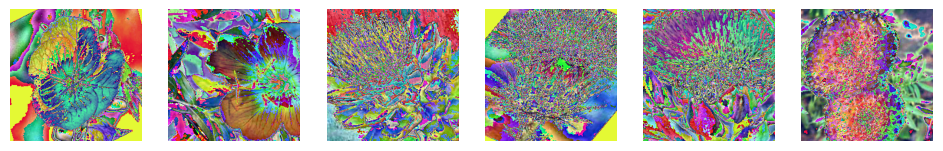

In [ ]:
display_image_grid([
    flowers_train_dataset[0][0],
    flowers_train_dataset[1][0],
    flowers_train_dataset[1019][0],
    flowers_train_dataset[1020][0],
    flowers_train_dataset[1021][0],
    flowers_train_dataset[2039][0],
])


# Flowers 102 train/val data loaders

In [ ]:
# Dataloaders
flowers_train_loader = torch.utils.data.DataLoader(
  flowers_train_dataset,
  batch_size=16,
  shuffle=True,
)

flowers_test_loader = torch.utils.data.DataLoader(
  flowers_test_dataset,
  batch_size=16,
  shuffle=False,
)

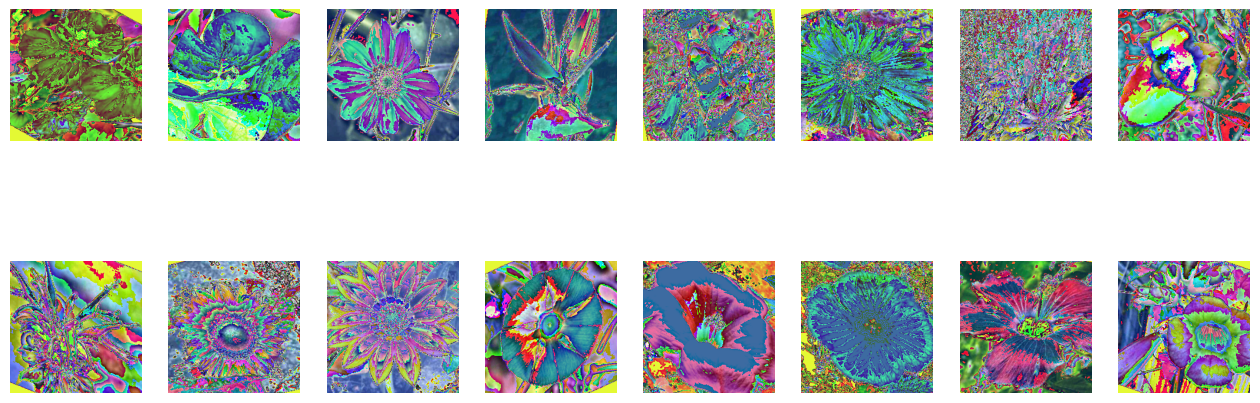

In [ ]:
inputs, targets = next(iter(flowers_train_loader))
display_image_grid(inputs, images_per_row=8)

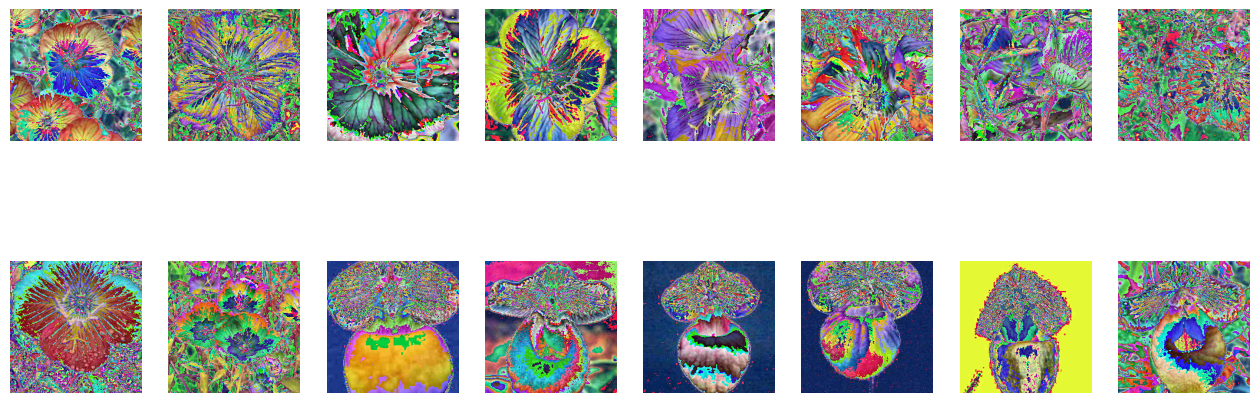

In [ ]:
display_image_grid(next(iter(flowers_test_loader))[0])
# t2img(flowers_train_dataset[0][0]), t2img(flowers_test_dataset[0][0])

# Use torchinfo.summary to check which layers can be trained

In [ ]:
# Let's visually inspect a validate if the requires_grad parameter is set correctly
# on the respective layers of the model during feature-extraction. Providing an
# input shape also lets us see how much memory we will need during a forward and
# backward pass of the model. Based on the data, it seems like getting the backward
# pass to run on the ResNet152 model on a P100 GPU might be challenging, so we
# use a batch size of 16 during training.
for backbone in backbones:
    fc_test = Flowers102Classifier(backbone=backbone, load_pretrained=False)
    fc_test.fine_tune(FineTuneType.NEW_LAYERS)

    print(summary(
        fc_test,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
    ))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
Flowers102Classifier                     [32, 3, 224, 224]         [32, 102]                 --                        Partial
├─VGG: 1-1                               [32, 3, 224, 224]         [32, 102]                 --                        Partial
│    └─Sequential: 2-1                   [32, 3, 224, 224]         [32, 512, 7, 7]           --                        False
│    │    └─Conv2d: 3-1                  [32, 3, 224, 224]         [32, 64, 224, 224]        (1,792)                   False
│    │    └─BatchNorm2d: 3-2             [32, 64, 224, 224]        [32, 64, 224, 224]        (128)                     False
│    │    └─ReLU: 3-3                    [32, 64, 224, 224]        [32, 64, 224, 224]        --                        --
│    │    └─Conv2d: 3-4                  [32, 64, 224, 224]        [32, 64, 224, 224]        (36,928)                  F

# Transfer Learning (feature extraction + fine tuning)

Running feature extraction on a vgg16 backbone for 16 epochs.



Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /kaggle/working/torchvision_models/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:07<00:00, 78.4MB/s]


Accuracy of vgg16-based pre-trained model with last layer replaced.
[0] Val Loss: 4.66245, Accuracy: 0.01123
[1] Train Loss: 1.46454
[1] Train Loss: 0.40738, Accuracy: 0.89692
[1] Val Loss: 0.60843, Accuracy: 0.83447
Current valdation accuracy 83.45 is better than previous best of 0.00. Saving checkpoint.
[2] Train Loss: 0.61809
[2] Train Loss: 0.27646, Accuracy: 0.92516
[2] Val Loss: 0.52727, Accuracy: 0.84277
Current valdation accuracy 84.28 is better than previous best of 83.45. Saving checkpoint.
[3] Train Loss: 0.53983
[3] Train Loss: 0.22831, Accuracy: 0.93328
[3] Val Loss: 0.48315, Accuracy: 0.85791
Current valdation accuracy 85.79 is better than previous best of 84.28. Saving checkpoint.
[4] Train Loss: 0.47535
[4] Train Loss: 0.18391, Accuracy: 0.94724
[4] Val Loss: 0.42140, Accuracy: 0.87451
Current valdation accuracy 87.45 is better than previous best of 85.79. Saving checkpoint.
[5] Train Loss: 0.43944
[5] Train Loss: 0.14870, Accuracy: 0.95633
[5] Val Loss: 0.41870, Accura

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /kaggle/working/torchvision_models/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 28.7MB/s]


Accuracy of resnet50-based pre-trained model with last layer replaced.
[0] Val Loss: 4.63774, Accuracy: 0.00830
[1] Train Loss: 2.39450
[1] Train Loss: 1.08144, Accuracy: 0.88195
[1] Val Loss: 1.53504, Accuracy: 0.77881
Current valdation accuracy 77.88 is better than previous best of 0.00. Saving checkpoint.
[2] Train Loss: 0.91076
[2] Train Loss: 0.55193, Accuracy: 0.94692
[2] Val Loss: 0.87221, Accuracy: 0.87793
Current valdation accuracy 87.79 is better than previous best of 77.88. Saving checkpoint.
[3] Train Loss: 0.55830
[3] Train Loss: 0.34983, Accuracy: 0.96737
[3] Val Loss: 0.64007, Accuracy: 0.89795
Current valdation accuracy 89.79 is better than previous best of 87.79. Saving checkpoint.
[4] Train Loss: 0.39880
[4] Train Loss: 0.26072, Accuracy: 0.97630
[4] Val Loss: 0.52192, Accuracy: 0.91602
Current valdation accuracy 91.60 is better than previous best of 89.79. Saving checkpoint.
[5] Train Loss: 0.30088
[5] Train Loss: 0.18353, Accuracy: 0.98036
[5] Val Loss: 0.43196, Acc

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /kaggle/working/torchvision_models/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:13<00:00, 18.1MB/s]


Accuracy of resnet152-based pre-trained model with last layer replaced.
[0] Val Loss: 4.63561, Accuracy: 0.01611
[1] Train Loss: 2.23949
[1] Train Loss: 1.12774, Accuracy: 0.85435
[1] Val Loss: 1.59476, Accuracy: 0.74561
Current valdation accuracy 74.56 is better than previous best of 0.00. Saving checkpoint.
[2] Train Loss: 0.81123
[2] Train Loss: 0.59523, Accuracy: 0.93195
[2] Val Loss: 0.97676, Accuracy: 0.84033
Current valdation accuracy 84.03 is better than previous best of 74.56. Saving checkpoint.
[3] Train Loss: 0.51057
[3] Train Loss: 0.43807, Accuracy: 0.96006
[3] Val Loss: 0.79485, Accuracy: 0.87549
Current valdation accuracy 87.55 is better than previous best of 84.03. Saving checkpoint.
[4] Train Loss: 0.36575
[4] Train Loss: 0.30893, Accuracy: 0.96899
[4] Val Loss: 0.62724, Accuracy: 0.88721
Current valdation accuracy 88.72 is better than previous best of 87.55. Saving checkpoint.
[5] Train Loss: 0.28818
[5] Train Loss: 0.22350, Accuracy: 0.97971
[5] Val Loss: 0.54207, Ac

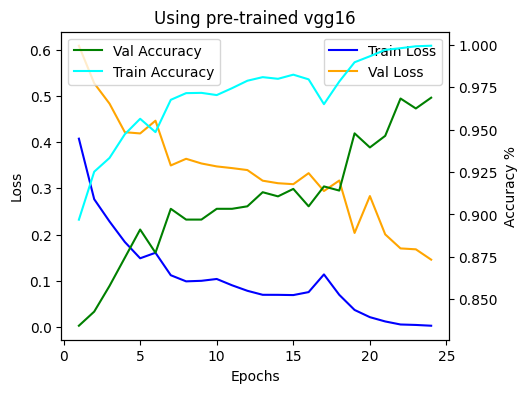

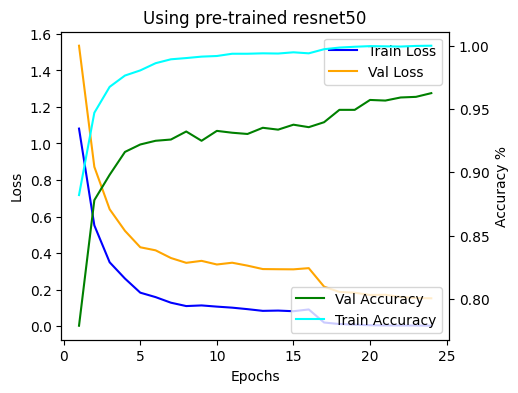

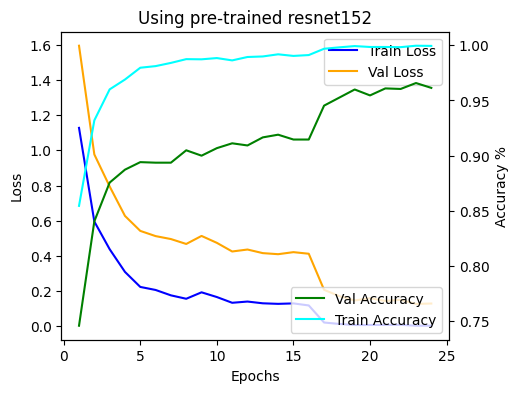

In [ ]:
def transfer_learning_on_backbone(backbones, feature_extract_epochs, fine_tune_epochs):
    """Run transfer learning on multiple backbones for this classification task.
    The choice of the backbone (pre-trained model) is a hyper-parameter.

    We perform transfer-learning in 2 steps:
    1. Feature extraction, which is run for feature_extract_epochs, and
    2. Fine-tuning, which is run for fine_tune_epochs.

    We save the model with the best validation accuracy after every epoch.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # Let's train the last classification later of the pre-trained model with the
    # specified backbone on the Flowers 102 dataset.

    training_runs = {}
    for backbone in backbones:
        best_cp_path = f'{backbone}_Flowers102_best.pt'
        print(f"Running feature extraction on a {backbone} backbone for {feature_extract_epochs} epochs.\n")
        fc = Flowers102Classifier(backbone=backbone, load_pretrained=True)
        fc.to(device)

        optimizer = torch.optim.Adam(fc.parameters())
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.3)
        accuracy = MulticlassAccuracy(num_classes=102, average='micro').to(device)

        # Evaluate accuracy of the untuned classifier model on the test dataset.
        print(f"Accuracy of {backbone}-based pre-trained model with last layer replaced.")
        fc.eval()
        fc.evaluate(flowers_test_loader, accuracy, 0, "Val")

        # First freeze all the weights except for the newly added Linear layer.
        fc.fine_tune(FineTuneType.NEW_LAYERS)

        best_test_accuracy = 0.0
        training_run = TrainingRun()
        training_runs[backbone] = training_run

        fc.train_multiple_epochs_and_save_best_checkpoint(
            flowers_train_loader,
            flowers_test_loader,
            accuracy,
            optimizer,
            scheduler,
            feature_extract_epochs,
            best_cp_path,
            training_run,
        )

        print(f"Done with feature extraction for {backbone}-based model. Ran for {feature_extract_epochs} epochs.")

        best_val_accuracy = fc.get_metrics("val")['accuracy']
        print(f"[{backbone}] Best val accuracy after feature extraction is {best_val_accuracy}\n")
        print(f"Running fine-tuning for {fine_tune_epochs} epochs")

        # Set all the parameters to be trainable.
        fc.fine_tune(FineTuneType.ALL)

        optimizer = torch.optim.Adam(fc.get_optimizer_params(), lr=1e-8)
        # Every 2 steps reduce the LR to 70% of the previous value.
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7)

        fc.train_multiple_epochs_and_save_best_checkpoint(
            flowers_train_loader,
            flowers_test_loader,
            accuracy,
            optimizer,
            scheduler,
            fine_tune_epochs,
            best_cp_path,
            training_run,
        )

        best_val_accuracy = fc.get_metrics("val")['accuracy']
        print(f"[{backbone}] Best val accuracy after fine-tuning is {best_val_accuracy}\n")
    # end for (backbone)

    # Now plot the training runs.
    plot_training_runs(training_runs)
# end def

transfer_learning_on_backbone(backbones, feature_extract_epochs=16, fine_tune_epochs=8)